# FODS Assignment 1

In [517]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [518]:
df = pd.read_csv("./data.csv")

In [519]:
df.head()

,X,Y
0,0.987988,5.098368
1,0.719720,2.516654
2,-0.403403,0.337961
3,0.107107,0.737320
4,0.345345,-0.780955


## TASK 1

In [520]:
mean_y = df['Y'].mean()
std_y = df['Y'].std()

### Normalizing 

In [521]:
df['Y'] = (df['Y'] - mean_y) / std_y

In [522]:
df.tail()

,X,Y
995,0.671672,1.174380
996,-0.615616,-0.512541
997,0.259259,0.062779
998,0.119119,-0.392207
999,0.369369,-0.226423


In [523]:
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
train_set, test_set, val_set = df[:600], df[600:800], df[800:1000]

In [524]:
print("Training Set:")
print(train_set)
print("\nTesting Set:")
print(test_set)

Training Set:
            X         Y
0   -0.851852 -1.119315
1   -0.853854 -2.033919
2    0.159159  0.660240
3   -0.617618 -0.348264
4   -0.219219  0.315293
..        ...       ...
595  0.951952  1.762817
596  0.751752  0.377742
597  0.009009 -0.167036
598  0.519520 -0.531118
599  0.667668  0.644588

[600 rows x 2 columns]

Testing Set:
            X         Y
600 -0.649650 -0.204448
601 -0.433433  0.694214
602  0.859860  2.243923
603  0.573574  0.734657
604  0.431431  0.146584
..        ...       ...
795 -0.125125  0.023610
796  0.479479 -0.277378
797  0.243243 -0.154319
798 -0.437437  0.403846
799 -0.927928 -1.061514

[200 rows x 2 columns]


### Visualizing

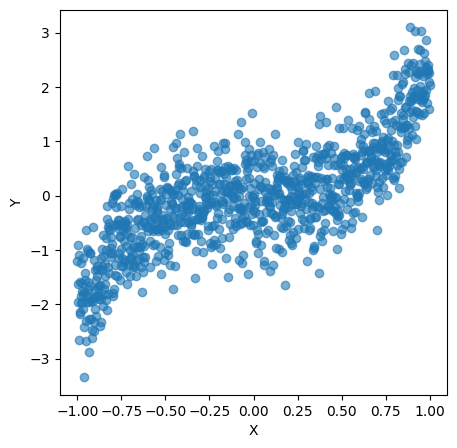

In [525]:
plt.figure(figsize=(5, 5))
scatter = plt.scatter(df['X'], df['Y'], alpha = 0.6)

plt.xlabel('X')
plt.ylabel('Y')

plt.show()

## Task 2

#### Pre-compute helper function for calulating the polynomial values for all the X values

In [526]:
def pre_compute(X, deg):
    return np.array([X ** i for i in range(deg + 1)]).T

In [527]:
def compute_error(poly_matrix, Y, w):
    error = 0
    N = len(Y)
    for i in range(N):
        error += (np.dot(poly_matrix[i], w) - Y[i]) ** 2    
    return error / (2 * N)


In [528]:
def gradient(poly_matrix, Y, w):

    err = (np.dot(poly_matrix, w)) - Y
    slope = np.dot(poly_matrix.T, err)
    return slope

In [611]:
def gradient_descent(poly_matrix, Y, w):
    
    w_old = w.copy()
    w -= 0.0001 * gradient(poly_matrix, Y, w_old)

    return w

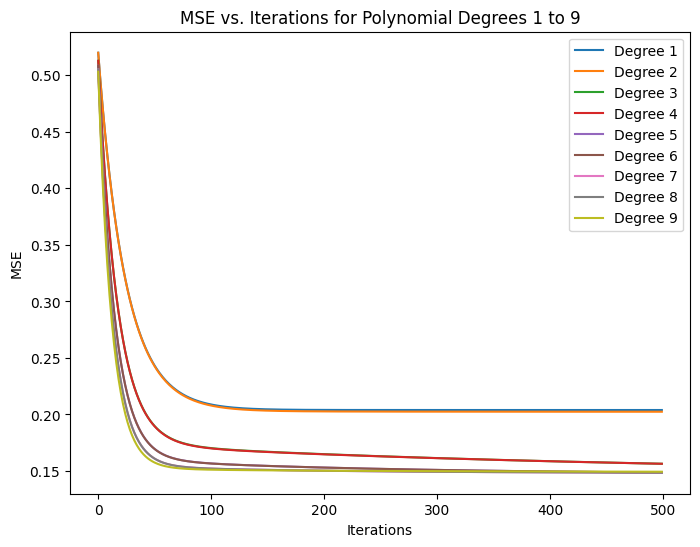

In [612]:
all_errors = {}

for deg in range(1, 10):
    errors = []
    w = np.zeros(deg + 1)
    polynomial = pre_compute(train_set['X'], deg)

    for itr in range(500):

        w = gradient_descent(
            polynomial,
            train_set['Y'],
            w
        )

        error = compute_error(polynomial, train_set['Y'], w)
        errors.append(error)

    all_errors[deg] = errors

plt.figure(figsize=(8, 6))
for deg, errors in all_errors.items():
    plt.plot(errors, label=f"Degree {deg}")

plt.xlabel("Iterations")
plt.ylabel("MSE")
plt.title("MSE vs. Iterations for Polynomial Degrees 1 to 9")
plt.legend()
plt.show()

### All correct, no errors

## Regularization

In [613]:
def compute_error_val(poly_matrix, Y, w):
    error = 0
    N = len(Y)
    for i in range(200):
        error += (np.dot(poly_matrix[i], w) - Y[i + 800]) ** 2    
    return error / (2 * N)


In [614]:

from math import exp


def gradient_l2(poly_matrix, Y, w, l2_lambda):

    err = (np.dot(poly_matrix, w)) - Y
    slope = np.dot(poly_matrix.T, err)
    slope += exp(l2_lambda) * w
    return slope


In [618]:
def gradient_descent_l2(poly_matrix, Y, w, l2_lambda):
    
    w_old = w.copy()
    w -= 0.0001 * gradient_l2(poly_matrix, Y, w_old, l2_lambda)

    return w

In [619]:
all_bias = {}
all_variance = {}
all_total_error = {}

lambdas = np.linspace(0, 1, 10)
lambdas = np.clip(lambdas, 1e-10, None) 

for deg in range(1, 10):
    deg_bias = []
    deg_variance = []
    total_error = []

    w = np.zeros(deg + 1)
    polynomial1 = pre_compute(train_set['X'], deg)
    polynomial2 = pre_compute(val_set['X'], deg)

    for ln_lambda in lambdas:

        # Train the model
        for itr in range(500):
                
            w = gradient_descent_l2(
                polynomial1,
                train_set['Y'],
                w,
                ln_lambda
            )

        # From training set
        bias_2 = compute_error(polynomial1, train_set['Y'], w)

        # from validation set
        variance = compute_error_val(polynomial2, val_set['Y'], w)
            
        deg_bias.append(bias_2)
        deg_variance.append(variance)
        total_error.append(bias_2 + variance)

    all_bias[deg] = deg_bias
    all_variance[deg] = deg_variance
    all_total_error[deg] = total_error

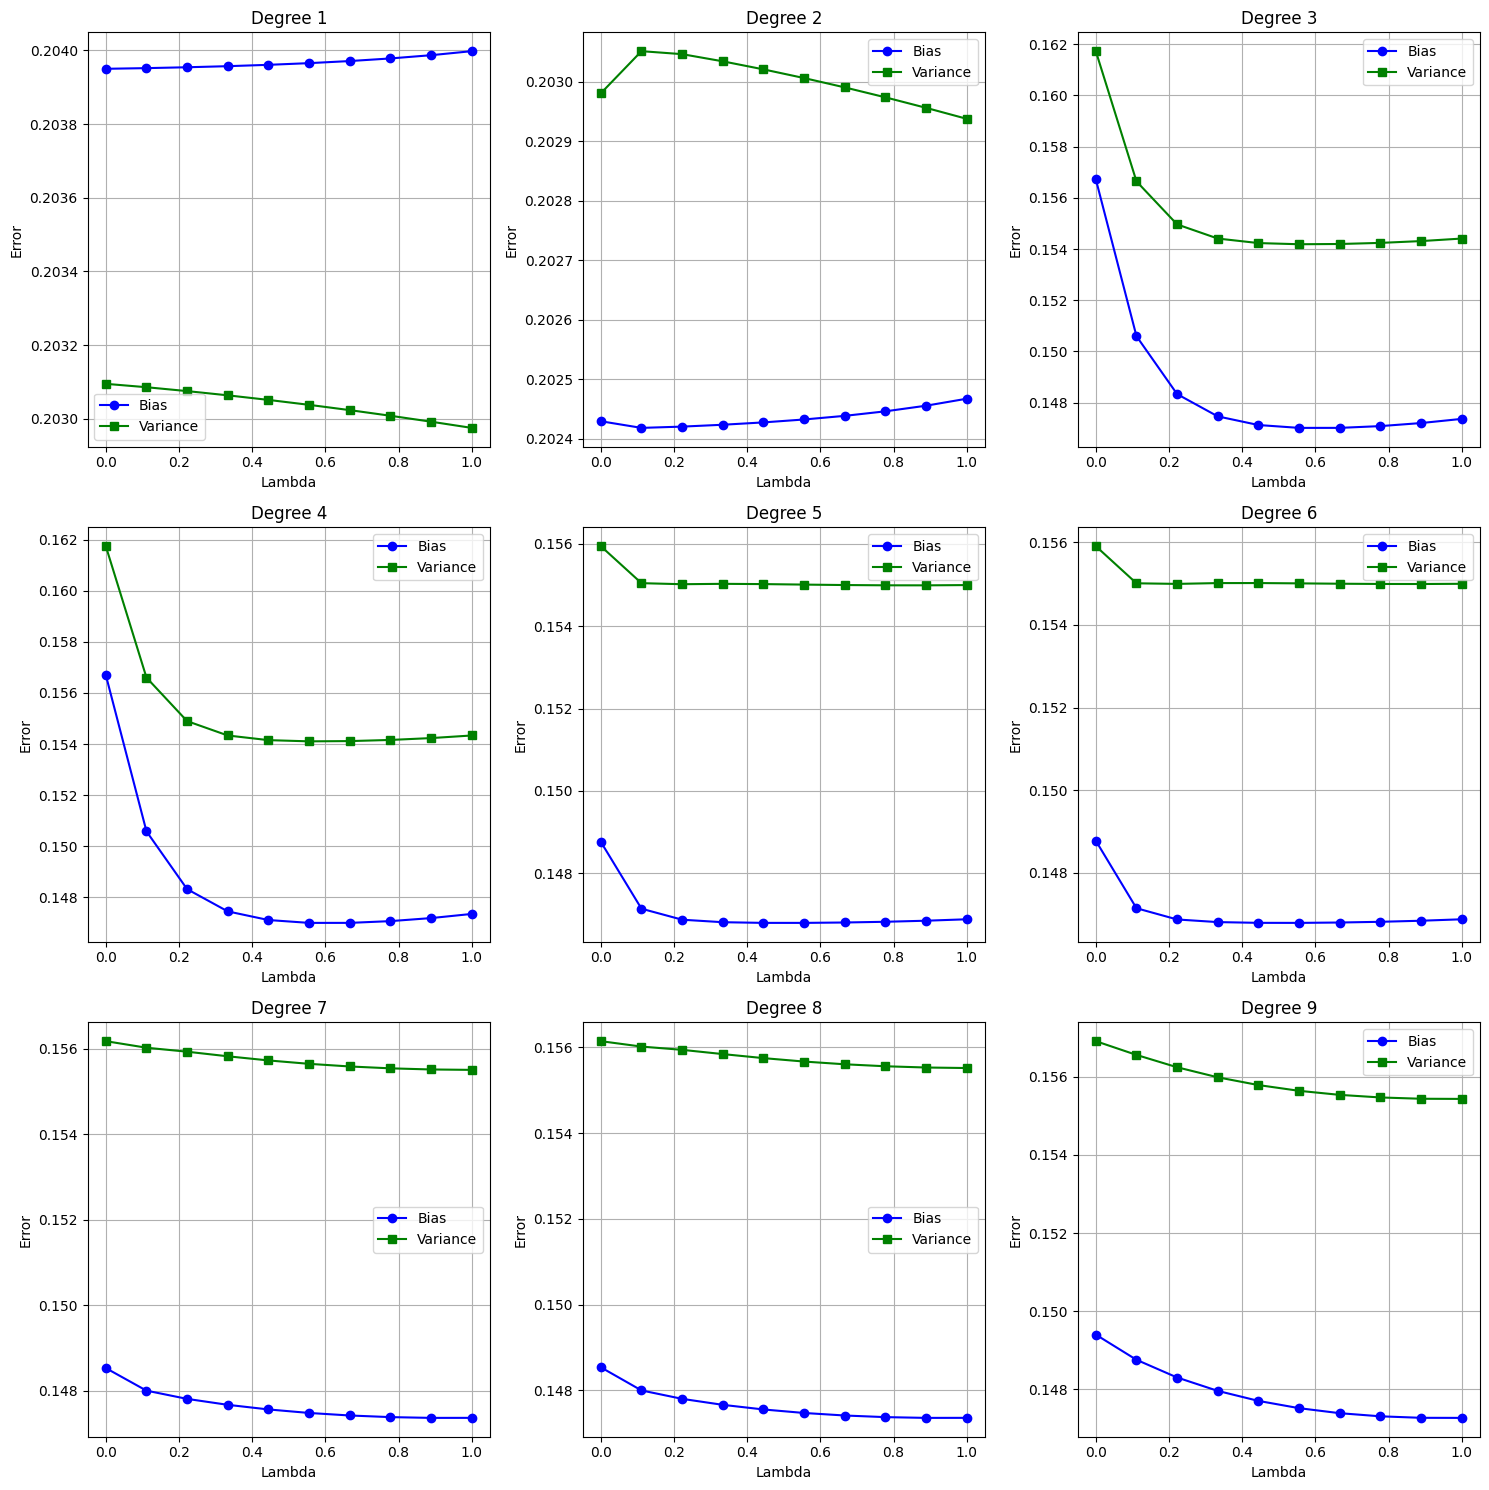

In [620]:
log_lambdas = np.log(lambdas)

fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()  # Flatten the 3x3 grid of subplots

# Loop over each degree and plot bias, variance, and total error
for deg in range(1, 10):
    ax = axes[deg - 1]
    
    # Plot bias, variance, and total error
    ax.plot(lambdas, all_bias[deg], label='Bias', color='blue', marker='o')
    ax.plot(lambdas, all_variance[deg], label='Variance', color='green', marker='s')
    # ax.plot(lambdas, all_total_error[deg], label='Total Error', color='red', marker='x')
    
    ax.set_title(f'Degree {deg}')
    ax.set_xlabel('Lambda')
    ax.set_ylabel('Error')
    ax.legend()
    ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

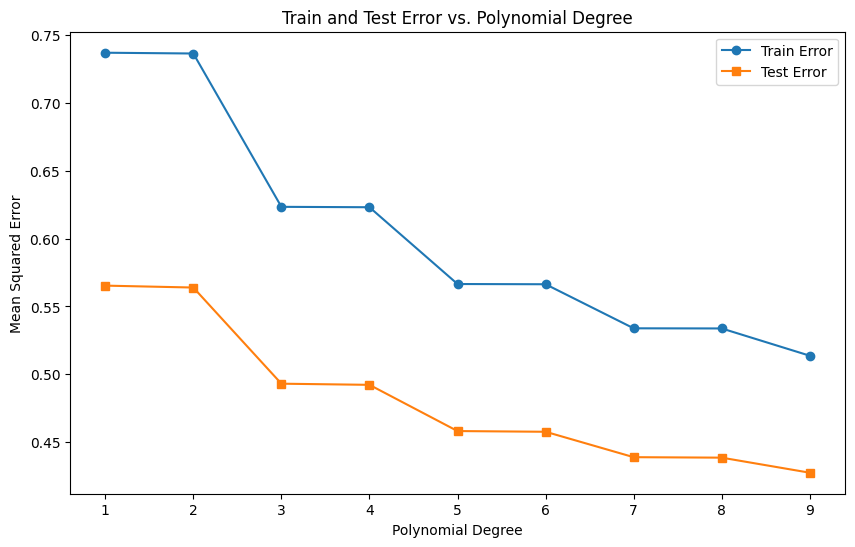

In [621]:
def gradient_descent_L2_vectorized(X, y, w, ln_lambda, learning_rate=0.001, max_iter=500, batch_size=200):
    N = len(y)
    for itr in range(max_iter):
        for start in range(0, N, batch_size):
            end = min(start + batch_size, N)
            X_batch = X[start:end]
            y_batch = y[start:end]
            predictions = np.dot(X_batch, w)
            errors = predictions - y_batch
            grad = (1 / len(y_batch)) * np.dot(X_batch.T, errors) + ln_lambda * w
            w -= learning_rate * grad
    return w

def compute_error_L2_vectorized(X, y, w):
    predictions = np.dot(X, w)
    errors = predictions - y
    return np.mean(errors ** 2)

degrees = range(1, 10)
train_errors = []
test_errors = []

for deg in degrees:
    X_train_design = pre_compute(train_set['X'].values, deg)
    X_test_design = pre_compute(test_set['X'].values, deg)

    y_train = train_set['Y'].values
    y_test = test_set['Y'].values

    w = np.zeros(deg + 1)

    w = gradient_descent_L2_vectorized(X_train_design, y_train, w, ln_lambda=0.5, max_iter=500)

    train_error = compute_error_L2_vectorized(X_train_design, y_train, w)
    test_error = compute_error_L2_vectorized(X_test_design, y_test, w)

    train_errors.append(train_error)
    test_errors.append(test_error)

plt.figure(figsize=(10, 6))
plt.plot(degrees, train_errors, label='Train Error', marker='o')
plt.plot(degrees, test_errors, label='Test Error', marker='s')
plt.xlabel('Polynomial Degree')
plt.ylabel('Mean Squared Error')
plt.title('Train and Test Error vs. Polynomial Degree')
plt.legend()
plt.show()


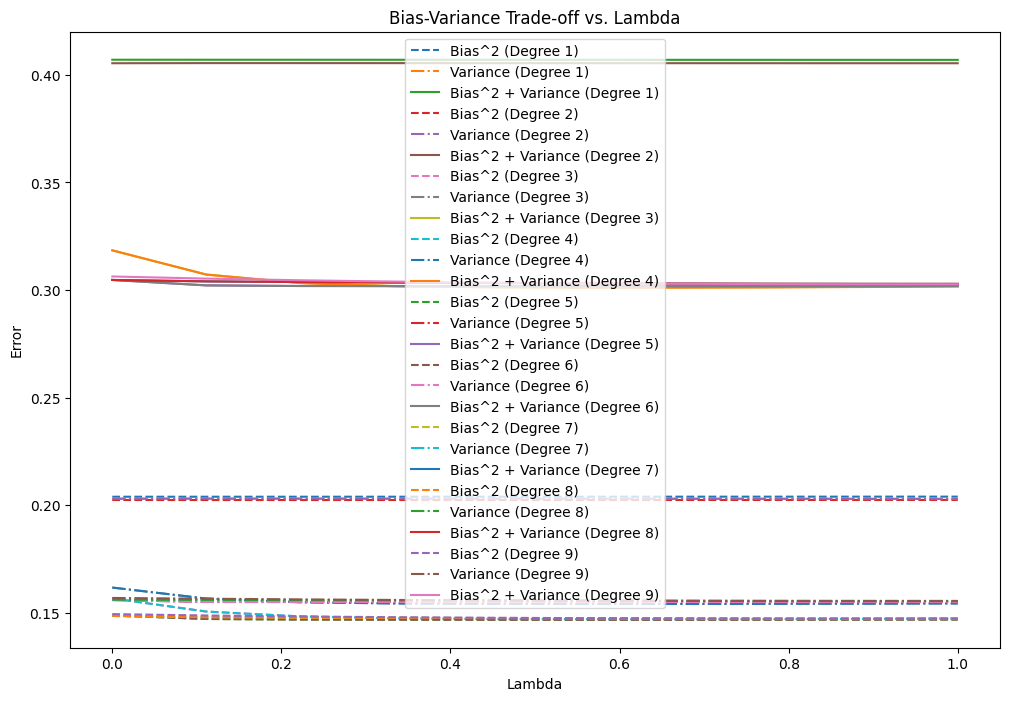

In [622]:
plt.figure(figsize=(12, 8))
for deg in degrees:
    plt.plot(lambdas, all_bias[deg], label=f"Bias^2 (Degree {deg})", linestyle='--')
    plt.plot(lambdas, all_variance[deg], label=f"Variance (Degree {deg})", linestyle='-.')
    plt.plot(lambdas, all_total_error[deg], label=f"Bias^2 + Variance (Degree {deg})", linestyle='-')

plt.xlabel("Lambda")
plt.ylabel("Error")
plt.title("Bias-Variance Trade-off vs. Lambda")
plt.legend()
plt.show()

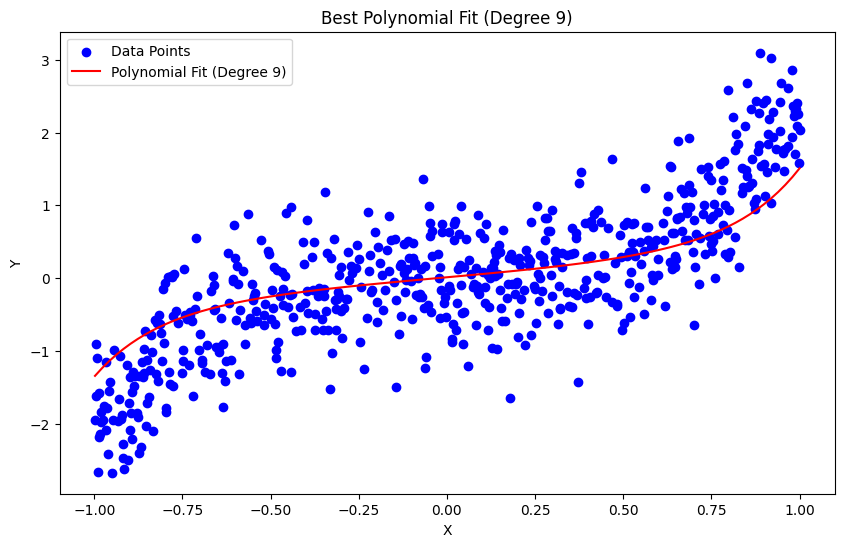

In [623]:
best_deg = degrees[np.argmin(test_errors)]  # Get degree with lowest test error

X_train_design_best = pre_compute(train_set['X'].values, best_deg)
y_train = train_set['Y'].values

w_best = np.zeros(best_deg + 1)
w_best = gradient_descent_L2_vectorized(X_train_design_best, y_train, w_best, ln_lambda=0.01, max_iter=500)

X_plot = np.linspace(min(train_set['X'].values), max(train_set['X'].values), 100)
X_plot_design = pre_compute(X_plot, best_deg)
y_plot = np.dot(X_plot_design, w_best)

plt.figure(figsize=(10, 6))
plt.scatter(train_set['X'], train_set['Y'], color='blue', label='Data Points')
plt.plot(X_plot, y_plot, color='red', label=f'Polynomial Fit (Degree {best_deg})')
plt.xlabel('X')
plt.ylabel('Y')
plt.title(f'Best Polynomial Fit (Degree {best_deg})')
plt.legend()
plt.show()

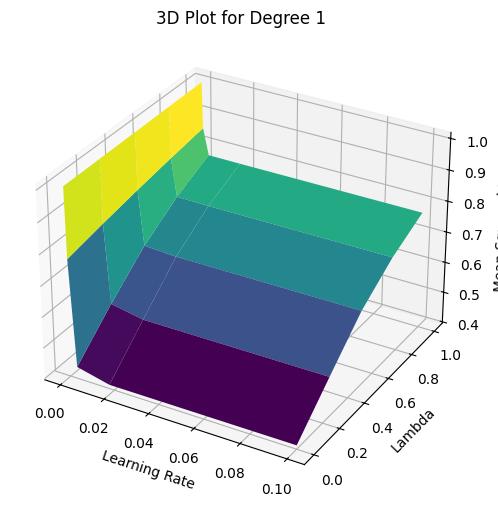

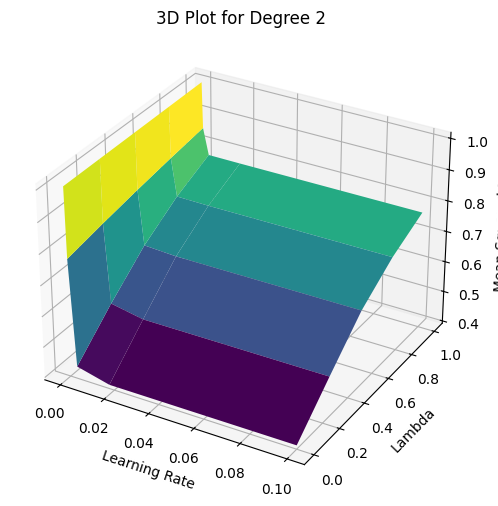

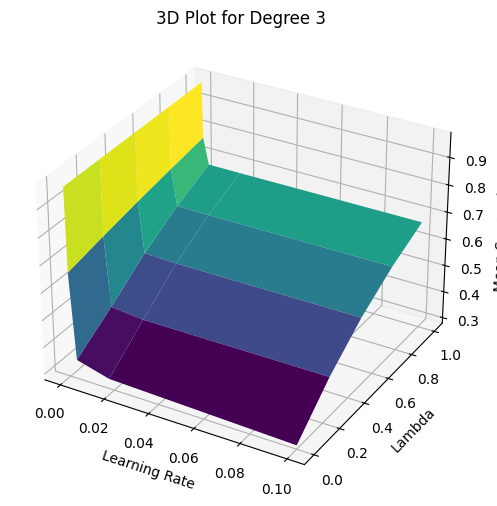

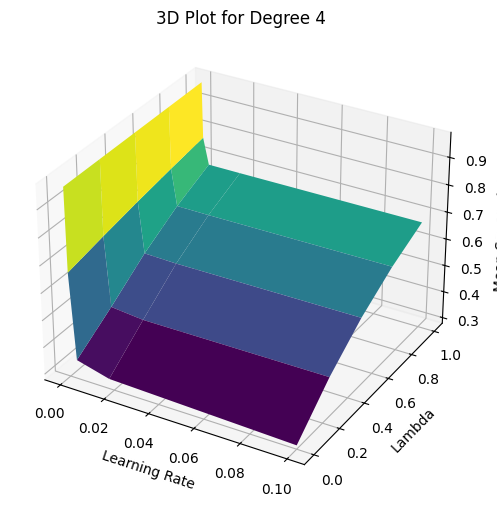

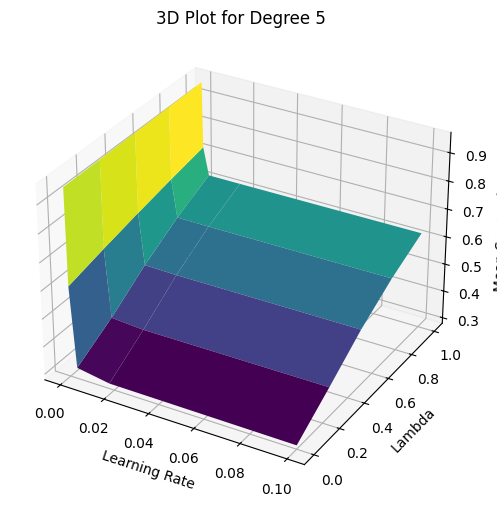

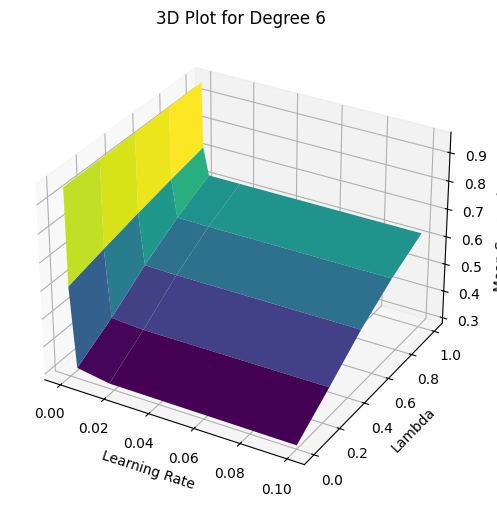

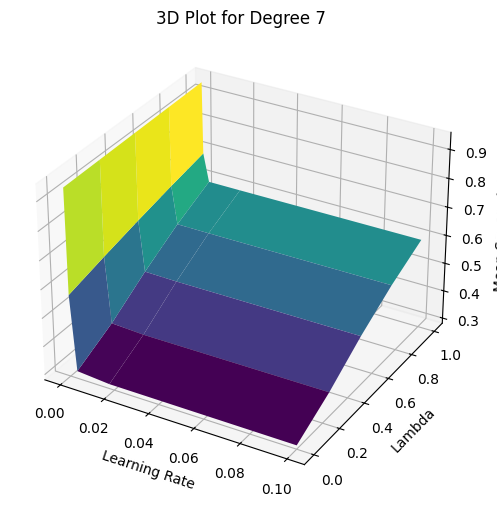

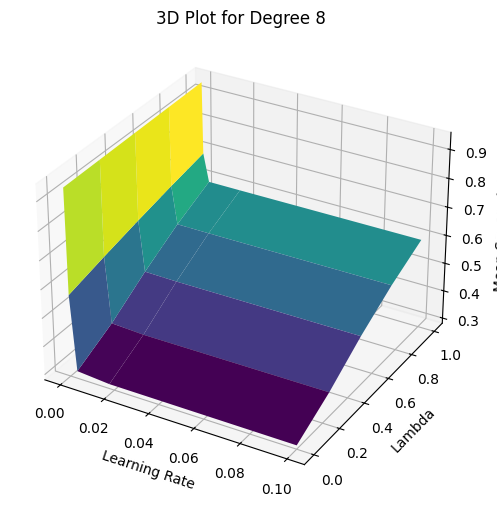

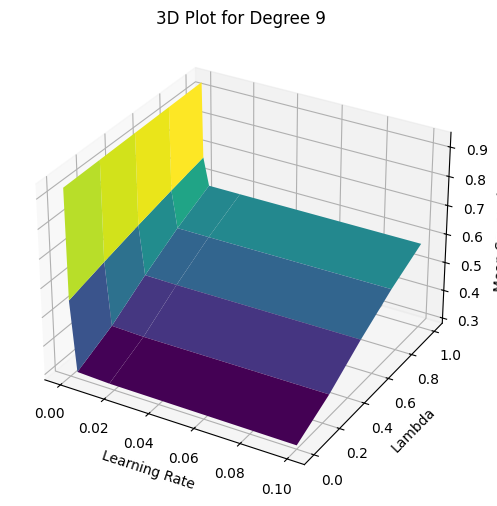

In [595]:
learning_rates = np.logspace(-4, -1, 5)
lambdas = np.linspace(0, 1, 5)           

mse_results = np.zeros((len(degrees), len(learning_rates), len(lambdas)))

for i, deg in enumerate(degrees):
    X_train_design = pre_compute(train_set['X'].values, deg)
    y_train = train_set['Y'].values

    for j, lr in enumerate(learning_rates):
        for k, ln_lambda in enumerate(lambdas):
            w = np.zeros(deg + 1)
            w = gradient_descent_L2_vectorized(X_train_design, y_train, w, ln_lambda, learning_rate=lr, max_iter=500)
            mse_results[i, j, k] = compute_error_L2_vectorized(X_train_design, y_train, w)

for i, deg in enumerate(degrees):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    lr_mesh, lambda_mesh = np.meshgrid(learning_rates, lambdas)
    mse_mesh = mse_results[i]

    ax.plot_surface(lr_mesh, lambda_mesh, mse_mesh.T, cmap='viridis')
    ax.set_xlabel('Learning Rate')
    ax.set_ylabel('Lambda')
    ax.set_zlabel('Mean Squared Error')
    ax.set_title(f'3D Plot for Degree {deg}')
    plt.show()
